# 导入包

In [1]:
import os
import cv2
import numpy as np
import pickle
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures # 用于构造高次项，在题2c中使用，拟合曲线
from sklearn.neighbors import KDTree                 # KNN

# 定义函数

In [2]:
def load_mat(filename):
    data = loadmat(filename)['data'].T
    return data
def show2dfig(X, labels=None):
    if X.shape[1] != 2: print('dimension error!'); return
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=labels)
    plt.show()
def show3dfig(X, labels=None):
    if X.shape[1] != 3: print('dimension error!'); return
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels)
    plt.show()
def angle(x, y):
    cosval = x.dot(y) / (np.linalg.norm(x)*np.linalg.norm(y))
    angval = np.arccos(np.clip(cosval, -1, 1)) * 180 / np.pi
    return angval

In [3]:
def exercise2a(X):
    n_samples = X.shape[0]
    show2dfig(X)

    # 对数据进行重建
    reduce_dim = PCA(n_component=2)
    X = reduce_dim.fit_transform(X)
    show2dfig(X)

    y = np.zeros(shape=(n_samples))

    # index = np.abs(X[:, 0]) < 0.15
    # y[index] = 1
    # show2dfig(X, y)

    hyperparaboloid = lambda x, y: x**2 - y**2	# 双曲抛物面/马鞍面
    z = hyperparaboloid(X[:, 0], X[:, 1])
    y[z > 0] = 1
    show2dfig(X, y)

    return y

# 定义类

In [4]:
class PCA():
    """ 主成分分析
    Attributes:
        n_component: {int} 主成分个数
        meanVal: {ndarray(n_features,)} 各维度的均值
        axis: {ndarray(n_features, n_component)}
    """
    def __init__(self, n_component=-1):
        self.n_component = n_component
        self.meanVal = None
        self.axis = None
    def fit(self, X, prop=0.99):
        ''' train the model
        Args:
            X: {ndarray(n_samples, n_features)}
            prop: {float}:  在[0, 1]范围内，表示取特征值之和占所有特征值的比重
        Notes:
            - `prop`参数仅在`n_component=-1`时生效
        '''
        # step 1: 去均值化
        self.meanVal = np.mean(X, axis=0)
        X_normalized = (X - self.meanVal)
        # step 2: 计算协方差矩阵
        cov = X_normalized.T.dot(X_normalized)
        # step 3: 特征值分解
        eigVal, eigVec = np.linalg.eig(cov)
        # 排序
        order = np.argsort(eigVal)[::-1]
        eigVal = eigVal[order]
        eigVec = eigVec.T[order].T
        # 若`n_component`未指定，则选择满足
        #   $$
        #   \frac{\sum_i \lambda_i}{\sum_{j=1}^n \lambda_j} \geq 0
        #   $$
        # 的`n_component`
        if self.n_component == -1:
            sumOfEigVal = np.sum(eigVal)
            sum_tmp = 0
            for k in range(eigVal.shape[0]):
                sum_tmp += eigVal[k]
                if sum_tmp > prop * sumOfEigVal:
                    self.n_component = k + 1
                    break
        # 选择主成分分量
        self.axis = eigVec[:, :self.n_component]
    def transform(self, X):
        """
        Args:
            降维
        Notes:
            X'_{nxk'} · V_{kxk'}^T = X''_{nxk}
        """
        # step 1: 去均值化
        X_normalized = X - self.meanVal
        # step 2: 投影
        X_transformed = X_normalized.dot(self.axis)
        return X_transformed
    def fit_transform(self, X, prop=0.99):
        self.fit(X, prop=prop)
        return self.transform(X)
    def transform_inv(self, X_transformed):
        """ 重构数据
        """
        X_restructured = X_transformed.dot(self.axis.T)
        X_restructured = X_restructured + self.meanVal
        return X_restructured

# 数据路径

In [5]:
"""
|-- 2015年全国研究生数学建模竞赛B题
    |-- 数据
        |-- 第1题数据
            |-- 1.mat
        |-- 第2题数据
            |-- 2a.mat
            |-- 2b.mat
            |-- 2c.mat
            |-- 2d.mat
        |-- 第3题数据
            |-- 3a.mat
            |-- 3b.mat
            |-- 3c.mat
        |-- 第4题数据
            |-- 4a.mat
            |-- 4b.mat
"""
data_path        = './2015年全国研究生数学建模竞赛B题/数据'
exercise1_fname  = '第1题数据/1.mat'
exercise2a_fname = '第2题数据/2a.mat'
exercise2b_fname = '第2题数据/2b.mat'
exercise2c_fname = '第2题数据/2c.mat'
exercise4a_fname = '第4题数据/4a.mat'

# 答题

## 第一题

1.当子空间独立时，子空间聚类问题相对容易。附件一中1.mat中有一组高维数据（.mat所存矩阵的每列为一个数据点，以下各题均如此），它采样于两个独立的子空间。请将该组数据分成两类。

In [6]:
X = load_mat(os.path.join(data_path, exercise1_fname))

数据降维

In [7]:
reduce_dim = PCA(n_component=2)
X_reduced = reduce_dim.fit_transform(X)
X_reduced = X_reduced.astype('float')

c:\myapplications\python3\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


`KMeans`聚类

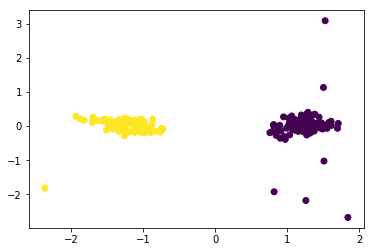

In [8]:
estimator = KMeans(n_clusters=2)
estimator.fit(X_reduced)
labels = estimator.predict(X_reduced)

show2dfig(X_reduced, labels)

## 第二题

请处理附件二中四个低维空间中的子空间聚类问题和多流形聚类问题。

### 2a
两条交点不在原点且互相垂直的两条直线，请将其分为两类

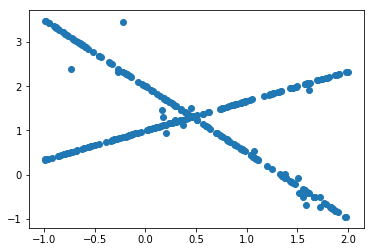

In [9]:
X = load_mat(os.path.join(data_path, exercise2a_fname))
n_samples = X.shape[0]
show2dfig(X)

利用`PCA`重构数据，去维度间的相关性

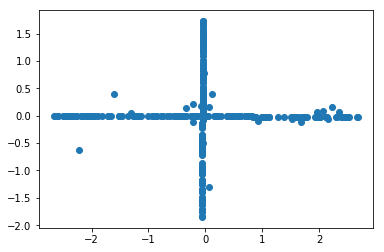

In [10]:
reduce_dim = PCA(n_component=2)
X = reduce_dim.fit_transform(X)
show2dfig(X)

这里用双曲抛物面将数据映射到高维(3d)空间

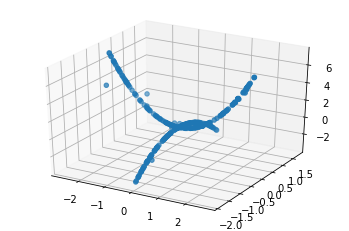

In [11]:
y = np.zeros(shape=(n_samples))

hyperparaboloid = lambda x, y: x**2 - y**2	# 双曲抛物面/马鞍面
z = hyperparaboloid(X[:, 0], X[:, 1])
show3dfig(np.c_[X, z])

进行分类

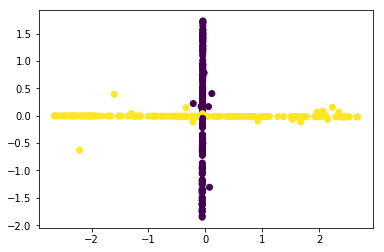

In [12]:
y[z > 0] = 1
show2dfig(X, y)

### 2b
图1(b)为一个平面和两条直线，这是一个不满足独立子空间的关系的例子，请将其分为三类。

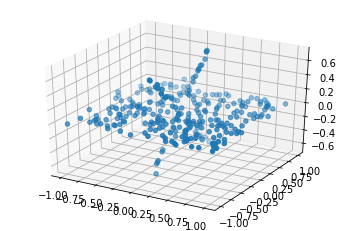

In [13]:
X = load_mat(os.path.join(data_path, exercise2b_fname))
n_samples = X.shape[0]
show3dfig(X)

利用`PCA`重构数据

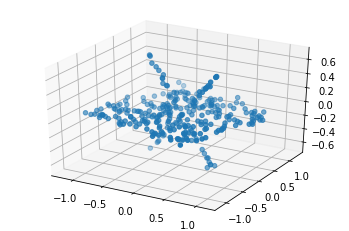

In [14]:
reduce_dim = PCA(n_component=3)
X = reduce_dim.fit_transform(X)
show3dfig(X)

将重构后的数据投影到第1、2主成分张成的平面$span\{v1, v2\}$上，这里用到了投影。

In [15]:
v = reduce_dim.axis[:, 0:2]
norm_res = np.zeros(shape=(n_samples,))
for i in range(n_samples):
    y_ = X[i]
    w = np.linalg.pinv(v).dot(y_)       # 投影 w* = (X^TX)^{-1} X^T y
    y__ = v.dot(w)
    # 计算与1、2主成分张成平面垂直的向量，这里记作res
    res = y__ - y_                      # 求解法向量
                                        # 或者也可直接将y_投影到第三主成分上作为法向量
    norm_res[i] = np.linalg.norm(res)

划分平面与直线，用法向量模的均值作为阈值

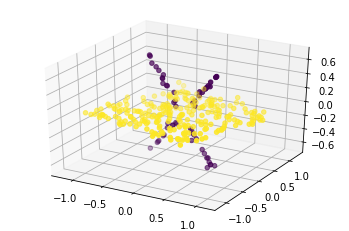

In [16]:
y = np.zeros(shape=(n_samples,))
# 取均值为阈值
thresh = np.mean(norm_res)
# 比阈值小即在平面内，标记为3
index = (norm_res<=thresh)
y[index] = 2
show3dfig(X, y)

剩下的直线部分用2a的方法求解

dimension error!


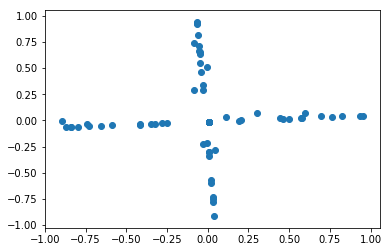

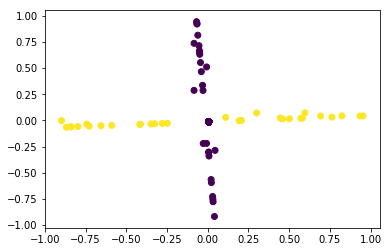

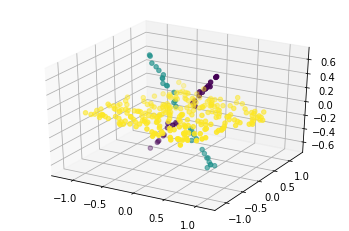

In [17]:
X_rest = X.copy()
X_rest[index] = np.array([0, 0, 0])
X_rest = reduce_dim.fit_transform(X_rest)
y[~index] = exercise2a(X_rest)[~index]

show3dfig(X, y)

### 2c
图1(c)为两条不相交的二次曲线，请将其分为两类。

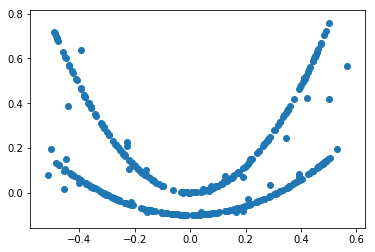

In [18]:
X = load_mat(os.path.join(data_path, exercise2c_fname))
n_samples = X.shape[0]
show2dfig(X)

用`PCA`重构数据

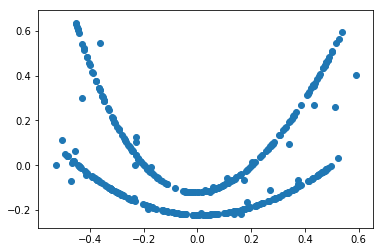

In [19]:
reduce_dim = PCA(n_component=3)
X = reduce_dim.fit_transform(X)
show2dfig(X)

用线性回归拟合两条曲线间的分割曲线

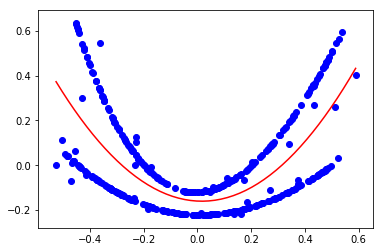

In [20]:
# 广义线性回归拟合两类点之间的曲线
ploy = PolynomialFeatures(degree=2)     # 构造 0, 1, 2次特征

x1 = X[:, 0].reshape((-1, 1))
x1_ = ploy.fit_transform(x1)             
x2_ = X[:, 1]
w = np.linalg.pinv(x1_).dot(x2_)
# 显示
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c='b')
x1__ = np.linspace(np.min(x1), np.max(x1))
x2__ = ploy.transform(x1__.reshape((-1, 1))).dot(w)
plt.plot(x1__, x2__, c='r')
plt.show()

进行分类

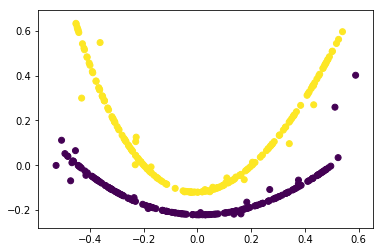

In [21]:
y = np.zeros(shape=(n_samples,))
y[x2_ > x1_.dot(w)] = 1
show2dfig(X, y)

## 第四题

### 4a
图3(a)分别显示了圆台的点云，请将点按照其所在的面分开(即圆台按照圆台的顶、底、侧面分成三类)。

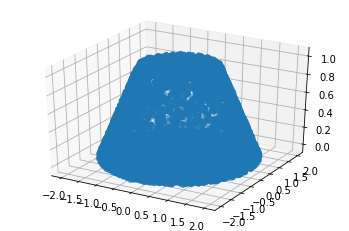

In [22]:
X = load_mat(os.path.join(data_path, exercise4a_fname))
n_samples = X.shape[0]
n_features = X.shape[1]
show3dfig(X)

用`PCA`对数据进行重构

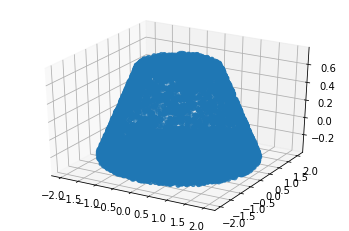

In [23]:
reduce_dim = PCA(n_component=3)
X = reduce_dim.fit_transform(X)
show3dfig(X)

利用`PCA`计算每个点切平面的法向量，运算量大，保存结果至`./data/vec.npy`

In [24]:
# 建立数据的KDTree
kdtree = KDTree(X, metric='euclidean')
vecs = np.zeros(shape=(n_samples, n_features))
I = np.eye(n_features); y_ = np.mean(X, axis=0)
for i in range(n_samples):
    # 10个近邻点组成近似平面
    X_i = X[i].reshape((1, -1))     # Reshape your data either using array.
                                    # reshape(-1, 1) if your data has a single feature or array.
                                    # reshape(1, -1) if it contains a single sample.
    idx = kdtree.query(X_i, 10-1, return_distance=False)
    X_nn = X[idx][0]
    pca = PCA(n_component=n_features)
    pca.fit(X_nn)
    vecs[i] = pca.axis[:, -1]   # 第三主成分直接作为法向量
np.save("./data/vec.npy", vecs)

分割平面

In [25]:
k=10; d=0.2; thresh=5

vecs = np.load("./data/vec.npy")

points = np.c_[X, np.zeros(n_samples)]       # 最后一列用于表示类别
Xrest = np.c_[X, np.zeros(n_samples), np.arange(n_samples)] # -1列对数据进行标号，表示与原数据的映射，-2列记录数据所属类别
nowMax = 1
while Xrest[Xrest[:, -2]==0].shape[0] > 0:   # 判断剩余矩阵的个数
    restRate = Xrest[Xrest[:, 3]==0].shape[0] / n_samples
    # print("剩余{:.2%}未标记".format(restRate))
    nowId = 0
    x0 = Xrest[nowId, :3]
    v0 = vecs[int(Xrest[nowId, -1])]        # 直接从 pca 结果中提取法向量
    while True:
        # 搜索d近邻内的点
        kdtree = KDTree(Xrest[:, :3], metric='euclidean')
        k_ = Xrest.shape[0] if Xrest.shape[0] < k else k
        dist, idx = kdtree.query(x0.reshape((1, -1)), k=k_)
        dist = dist[0]; idx = idx[0]
        idx = idx[dist<d]
        # 筛选角度小于阈值的点
        for i in range(idx.shape[0]):
            idx_ = idx[i]
            v1 = vecs[int(Xrest[idx_, 4])]
            ang = angle(v0, v1)
            if (ang < thresh) or (ang > 180 - thresh):
                points[int(Xrest[idx_, -1]), -1] = nowMax
                Xrest[idx_, -2] = nowMax
        # 移除当前点
        Xrest = np.delete(Xrest, nowId, axis=0)
        # 搜索同类别下一个点
        if Xrest[Xrest[:, 3]==nowMax].shape[0] > 0:
            for i in range(Xrest.shape[0]):
                if Xrest[i, -2] == nowMax:
                    nowId = i
                    x0 = Xrest[i, :3]
                    v0 = vecs[int(Xrest[i, -1])]
                    break
        else:
            nowMax += 1
            break

# 统计各类别样本点的个数
cnt = np.bincount(points[:, -1].astype('int'))  # 各标签计数
mainmark = np.argsort(cnt)[::-1]                # 按从多到少排序
# 标记各点
labels = points[:, -1].astype('int')
idx_1 = (labels==mainmark[0])                   # 确定为1的点的索引
idx_2 = (labels==mainmark[1])                   # 确定为2的点的索引
idx_3 = (labels==mainmark[2])                   # 确定为3的点的索引
points[idx_1, -1] = 1
points[idx_2, -1] = 2
points[idx_3, -1] = 3
idx_0 = ~(idx_1 + idx_2 + idx_3)                # 未确定标记的点索引
points[idx_0, -1] = 0                           # 将其标签置为0

# 将剩余的点归入最多的3个簇中
X_marked = np.c_[points, np.arange(n_samples)]  # 增加与原数据的映射列
# 建立KDTree
kdtree = KDTree(X_marked[:, :3], metric='euclidean')
while (X_marked[:, -2]==0).shape[0] > 0:
    Xrest = X_marked[X_marked[:, -2]==0]        # 提取出这些点
    n_rest = Xrest.shape[0]
    # print('{:2d} points left'.format(n_rest))
    if n_rest == 0: break
    idx_rest = np.random.randint(0, n_rest)
    idx = kdtree.query(Xrest[idx_rest, :3].reshape((1, -1)), k=20, return_distance=False)    # 查询最近的k_个点
    idx_labels = X_marked[idx.reshape(-1), -2].astype('int')
    cnt = np.bincount(idx_labels)               # 最近点所属类别计数
    if cnt.shape[0] == 1: continue
    X_marked[int(Xrest[idx_rest, -1]), -2] = np.argmax(cnt[1:]) + 1

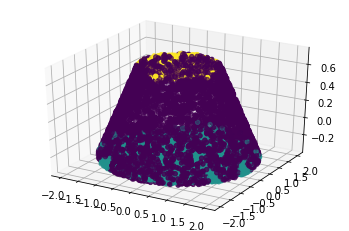

In [26]:
y = X_marked[:, -2].astype('int')
show3dfig(X, y)